Import Neccessary Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_probability as tfp
import tensorflow.keras.backend as K
print(f"TensorFlow Version: {tf.__version__}")

2024-11-15 00:42:42.823519: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731602562.836925   58858 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731602562.841080   58858 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-15 00:42:42.855683: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/divinevalleys/miniconda3/envs/tf-wsl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Ple

TensorFlow Version: 2.18.0


Data Loading and Preprocessing

In [2]:
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'oxford_flowers102',
    split=['test', 'validation', 'train'],
    shuffle_files=True,
    as_supervised=True,  # Include labels
    with_info=True
)
print(f"Dataset Info:\n{ds_info}")
num_classes = ds_info.features['label'].num_classes
print(f"Number of classes: {num_classes}")

I0000 00:00:1731602569.387126   58858 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21769 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:0a:00.0, compute capability: 8.6


Dataset Info:
tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/da

In [3]:
IMG_SIZE = 224  # You can adjust this size
BATCH_SIZE = 64  # You can adjust this size

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0  # Normalize to [0, 1]
    label = tf.one_hot(label, num_classes)  # Convert label to one-hot encoding
    return image, label


In [4]:
def mixup(batch_x, batch_y, alpha=0.2):
    batch_size = tf.shape(batch_x)[0]  # Get the actual batch size

    if alpha > 0:
        lam = tfp.distributions.Beta(alpha, alpha).sample([batch_size])
    else:
        lam = tf.ones([batch_size])

    lam_x = tf.reshape(lam, [batch_size, 1, 1, 1])  # For images
    lam_y = tf.reshape(lam, [batch_size, 1])        # For labels

    indices = tf.random.shuffle(tf.range(batch_size))
    batch_x2 = tf.gather(batch_x, indices)
    batch_y2 = tf.gather(batch_y, indices)

    # Mix images
    mixed_x = lam_x * batch_x + (1 - lam_x) * batch_x2

    # Mix labels (already one-hot encoded)
    mixed_y = lam_y * batch_y + (1 - lam_y) * batch_y2
    
    return mixed_x, mixed_y




In [5]:
# Build the training dataset
ds_train_mixup = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_train_mixup = ds_train_mixup.shuffle(1000)
ds_train_mixup = ds_train_mixup.batch(BATCH_SIZE)
ds_train_mixup = ds_train_mixup.map(
    lambda x, y: mixup(x, y, alpha=0.2),
    num_parallel_calls=tf.data.AUTOTUNE
)
ds_train_mixup = ds_train_mixup.prefetch(tf.data.AUTOTUNE)

# Use the same preprocessing function as for training
ds_val = ds_val.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Load Model

In [6]:
loaded_model = keras.models.load_model('flower_classification_model.keras')
#loaded_test_loss, loaded_test_accuracy = loaded_model.evaluate(ds_test)
#print(f'Loaded Model Test Accuracy: {loaded_test_accuracy*100:.4f}')

Applying MixUp to Training Data

Training

In [7]:
callbacks = [
    keras.callbacks.EarlyStopping(
        patience=50, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(
        'best_model.keras', save_best_only=True),
]

In [8]:
# Compile the model with categorical crossentropy
model_mixup = models.clone_model(loaded_model)
model_mixup.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
epochs = 250  # Adjust the number of epochs as needed

history_mixup = model_mixup.fit(
    ds_train_mixup,
    validation_data=ds_val,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/250


2024-11-15 00:43:18.880568: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
I0000 00:00:1731602600.788545   58975 cuda_dnn.cc:529] Loaded cuDNN version 90300


97/97 ━━━━━━━━━━━━━━━━━━━━ 32s 234ms/step - accuracy: 0.0224 - loss: 5.4495 - val_accuracy: 0.0098 - val_loss: 5.0337
Epoch 2/250
97/97 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.0350 - loss: 4.4640 - val_accuracy: 0.0147 - val_loss: 4.5788
Epoch 3/250
97/97 ━━━━━━━━━━━━━━━━━━━━ 18s 184ms/step - accuracy: 0.0577 - loss: 4.3089 - val_accuracy: 0.0225 - val_loss: 4.4730
Epoch 4/250
97/97 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - accuracy: 0.0633 - loss: 4.1637 - val_accuracy: 0.0314 - val_loss: 4.4176
Epoch 5/250
97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 166ms/step - accuracy: 0.0673 - loss: 4.1238 - val_accuracy: 0.0196 - val_loss: 4.5160
Epoch 6/250
97/97 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.0701 - loss: 4.0775 - val_accuracy: 0.0304 - val_loss: 4.2398
Epoch 7/250
97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 168ms/step - accuracy: 0.0804 - loss: 4.0066 - val_accuracy: 0.0275 - val_loss: 4.3264
Epoch 8/250
97/97 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.0836 - loss: 3.9699 - val_accuracy

In [10]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

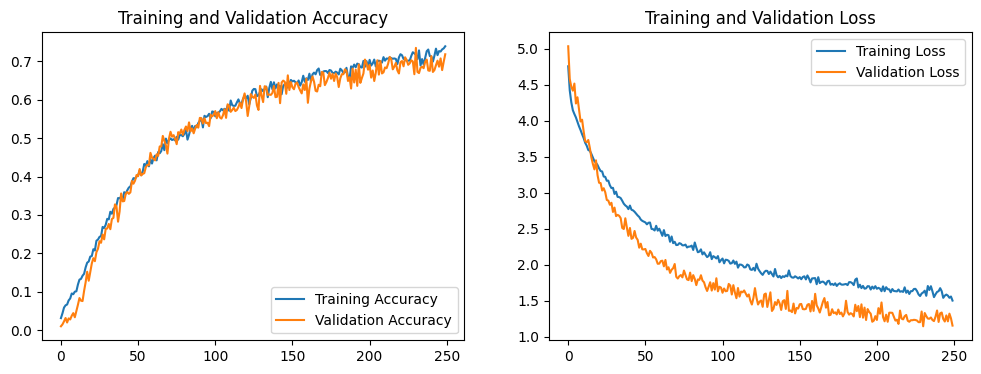

In [11]:
plot_history(history_mixup)

Evaluation

In [12]:
# Evaluate
test_loss, test_accuracy = model_mixup.evaluate(ds_test)
print(f"Test Accuracy with MixUp training data: {test_accuracy*100:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7178 - loss: 1.1344
Test Accuracy with MixUp training data: 70.8824
